# ResNetxMNIST

In [1]:
'''
 MyModel
    |
    |-- ResnetAlter
    |
    |-- SecModelxx
      


1. Load Model
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
    new_model = torch.nn.Sequential(*(list(model.children())[:-1]))
2. Load Image
    Datasets
    Dataloaders(batch, transform--preprocess)
3. Define Functions
    Loss
    Train
    Evaluate--test
4. Train and Analysis
'''
;

''

## 1. Import Resnet Pretrained

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

In [3]:
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
# model.eval()

# Select which model to implement
#model = torchvision.models.resnet18(pretrained=True)

# Drop the Last Layer
#resEmb = nn.Sequential(*(list(model.children())[:-1]))

# Change First Layer to 1x64x64 Input
#resEmb[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Define Custom Modules

In [5]:
# Define Altered ResNet
class ResnetAlter(nn.Module):
    def __init__(self):
        super(ResnetAlter, self).__init__()
        self.resEmb = nn.Sequential(*(list(torchvision.models.resnet18(pretrained=True).children())[:-1]))
        self.resEmb[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    def forward(self, x):
        return self.resEmb(x)

In [6]:
# Define Linear Layer After ResNet
class SecModel152(nn.Module):
    def __init__(self, dropout=0.5):
        super(SecModel152, self).__init__()
        self.linear1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.linear1(x.view(-1,2048)))
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        return self.linear3(x)

In [7]:
# Define Linear Layer After ResNet
class SecModel18(nn.Module):
    def __init__(self, dropout=0.5):
        super(SecModel18, self).__init__()
        self.linear1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.linear1(x.view(-1,512)))
        x = self.dropout1(x)
        return self.linear2(x)

In [8]:
# Define MyModel
class MyModel(nn.Module):
    def __init__(self, resnetAlter, secModel):
        super(MyModel, self).__init__()
        self.resnetAlter = resnetAlter
        self.secModel = secModel
    
    def forward(self, x):
        return self.secModel(self.resnetAlter(x))

In [9]:
# Initialize Weights of Linear Layers
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [10]:
# Create SecModel and initialize weights using xavier
# secModel18 = SecModel18()
# secModel18.apply(init_weights)

In [11]:
# No gradient for previous layers - x
# optimizer call to(device) - x
# criterion, loss - x
# weight - x
'''
# /Freeze parameters in Resnet
for param in resEmb.parameters():
    param.requires_grad = True

# Append 2 Models together
myModel = nn.Sequential(resEmb, secModel18)
myModel = myModel.to(device)
'''
;

''

In [12]:
'''
# Define Loss Function
criterion = nn.CrossEntropyLoss() # includes a logSoftmax layer and a loss layer
criterion = criterion.to(device)

# Optimizer--Adam
# although all parameters get passed in, only updates those marked with True
optimizer = torch.optim.Adam(model.parameters())
'''
;

''

## 3. Load Image and Preprocess

In [13]:
# Load Images with PIL
# Define Process Function for Train and Test Sets

from PIL import Image
from torchvision import transforms
preprocess_train = transforms.Compose([
    #transforms.Grayscale(3),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485+0.456+0.406)/3, std=(0.229+0.224+0.225)/3)
])
preprocess_test = transforms.Compose([
    #transforms.Grayscale(3),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485+0.456+0.406)/3, std=(0.229+0.224+0.225)/3)
])

In [14]:
'''
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]
'''
;

''

In [15]:
# Different Specified Datasets

mnist_trainset_tilt = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=preprocess_train)
mnist_trainset_orig = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=preprocess_test)

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=preprocess_test)
mnist_train_tilt, _ = torch.utils.data.random_split(mnist_trainset_tilt, lengths=[50000, 10000])
mnist_train_notilt, mnist_valid = torch.utils.data.random_split(mnist_trainset_orig, lengths=[50000, 10000])
mnist_train_double = torch.utils.data.ConcatDataset([mnist_train_tilt, mnist_train_notilt])



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [16]:
# Create DataLoader for Datasets

train_dataloader = DataLoader(mnist_train_tilt, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(mnist_valid, batch_size=256, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=256, shuffle=True)

Big_train_dataloader = DataLoader(mnist_trainset_tilt, batch_size=256, shuffle=True)
Double_train_dataloader = DataLoader(mnist_train_double, batch_size=256, shuffle=True)

## 4. Load Model Parameters

In [28]:
# Load Model From Local Drive
LOAD_PATH = 'checkpoint.pt'

resnetAlter = ResnetAlter()
secModel18 = SecModel18()

# -------- Don't Call if Load --------
secModel18.apply(init_weights)
# ------------------------------------

myModel = MyModel(resnetAlter, secModel18)

# -------- Call only to Load --------
#myModel.load_state_dict(torch.load(LOAD_PATH))
# -----------------------------------

myModel.to(device)
myModel.eval()

MyModel(
  (resnetAlter): ResnetAlter(
    (resEmb): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, ep

## 5. Training

In [29]:
# Define Loss Function
criterion = nn.CrossEntropyLoss() # includes a logSoftmax layer and a loss layer
criterion = criterion.to(device)

# Optimizer--Adam
# although all parameters get passed in, only updates those marked with True
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(myModel.parameters(), lr=3e-4)

In [30]:
# Define Train and Evaluate Function

def train(model, device, train_loader, valid_loader, optimizer, criterion, epoch, log_interval=1, dry_run=False, save=False):
    model.train()
    best_loss = np.inf
    for ep in range(1, epoch+1):
        current = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            current += len(data)
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, current, len(train_loader.dataset),
                    100. * current / len(train_loader.dataset), loss.item()))
                if dry_run:
                    break
        loss, _, _, _ = test(model, device, valid_loader, nn.CrossEntropyLoss(reduction='sum'))
        if save:
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), 'checkpoint.pt')
                print('***Model Updated***')

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    wrongx = []
    wrongy = []
    truey = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            selector = ~pred.eq(target.view_as(pred)).squeeze(1)
            # print(selector.shape)
            wrongx.append(data[selector])
            wrongy.append(pred[selector])
            truey.append(target[selector])
            #print(selector.shape)
            #print(data[selector].shape)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    wrongx = torch.cat( wrongx, dim=0 )
    wrongy = torch.cat( wrongy, dim=0 )
    truey = torch.cat( truey, dim=0 )
    return test_loss, wrongx, wrongy, truey

In [31]:
# Train Here

EPOCH = 3
'''
for e in range(EPOCH):
    print('Epoch',e+1)
    # train(myModel, device, train_dataloader, optimizer, criterion, epoch=1)
    train(myModel, device, Double_train_dataloader, optimizer, criterion, epoch=1)
    test(myModel, device, valid_dataloader, nn.CrossEntropyLoss(reduction='sum'))
'''
train(myModel, device, Double_train_dataloader, valid_dataloader, optimizer, criterion, EPOCH, save=False)

#wrongx, wrongy, truey = test(myModel, device, test_dataloader, nn.CrossEntropyLoss(reduction='sum'))

Train Epoch: 1 [256/100000 (0%)]	Loss: 3.343218
Train Epoch: 1 [512/100000 (1%)]	Loss: 1.954608
Train Epoch: 1 [768/100000 (1%)]	Loss: 0.997217
Train Epoch: 1 [1024/100000 (1%)]	Loss: 0.743792
Train Epoch: 1 [1280/100000 (1%)]	Loss: 0.690645
Train Epoch: 1 [1536/100000 (2%)]	Loss: 0.558543
Train Epoch: 1 [1792/100000 (2%)]	Loss: 0.381414
Train Epoch: 1 [2048/100000 (2%)]	Loss: 0.268872
Train Epoch: 1 [2304/100000 (2%)]	Loss: 0.264998
Train Epoch: 1 [2560/100000 (3%)]	Loss: 0.186587
Train Epoch: 1 [2816/100000 (3%)]	Loss: 0.147967
Train Epoch: 1 [3072/100000 (3%)]	Loss: 0.241251
Train Epoch: 1 [3328/100000 (3%)]	Loss: 0.148904
Train Epoch: 1 [3584/100000 (4%)]	Loss: 0.116394
Train Epoch: 1 [3840/100000 (4%)]	Loss: 0.182313
Train Epoch: 1 [4096/100000 (4%)]	Loss: 0.139487
Train Epoch: 1 [4352/100000 (4%)]	Loss: 0.103697
Train Epoch: 1 [4608/100000 (5%)]	Loss: 0.151338
Train Epoch: 1 [4864/100000 (5%)]	Loss: 0.117874
Train Epoch: 1 [5120/100000 (5%)]	Loss: 0.111355
Train Epoch: 1 [5376/10

## 6. Evaluation and Analysis

In [34]:
# Retireve Testset Results
_, wrongx, wrongy, truey = test(myModel, device, test_dataloader, nn.CrossEntropyLoss(reduction='sum'))


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)



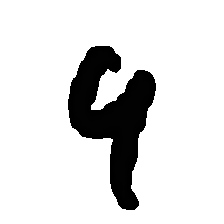

predicted label: 4
true label:      9


In [39]:
# Check Images That Were Classified Wrong
index = np.random.randint(0, len(wrongx))
ima = wrongx.cpu().numpy()[index][0].astype(np.uint8)
im = Image.fromarray(ima)
display(im)
print('predicted label:',wrongy.cpu().numpy()[index][0])
print('true label:     ',truey.cpu().numpy()[index])

## 7. Save Model

In [33]:
torch.save(myModel.state_dict(), 'checkpoint.pt')

In [32]:
'''
PARAMETERS of Best Result

MODEL: RESNET18(conv1-1x224x224) + LINEAR
DATASET: mnist_train_double
DEGREE = 15
BATCH_SIZE = 256
EPOCH = 3
lr = 3e-4
Accuracy = 99.53%
'''
;

''

In [40]:
# count = 0
# for p in myModel.parameters():
#   count += p.numel()
# print(count)